In [1]:
import numpy as np
import scipy
import scipy.integrate
from scipy.special import erf
import matplotlib.pyplot as plt
import os

# os.chdir('/Users/kcoppess/muspelheim/quail_volcano/src/')

# import compressible_conduit_steady.steady_state as SS
# import compressible_conduit_steady.material_properties as matprops

# os.chdir('/Users/kcoppess/muspelheim/quail_ODESS_map/')

import steady_state as SS
import material_properties as matprops

In [2]:
Numerics = {
  # Solution order; these correspond to:
  # 0: 1 node in each element representing the average value
  # 1: 2 nodes in each element constituting a linear representation of the
  #    solution in the element
  # 2: 3 nodes in each element constituting a quadratic representation of the
  #    solution in the element
  "SolutionOrder" : 2,
#   "SolutionBasis" : "LagrangeSeg",
#   "Solver" : "DG",
#   "ApplyLimiters" : "PositivityPreservingMultiphasevpT",
#   "ElementQuadrature" : "GaussLegendre",
#   "FaceQuadrature" : "GaussLegendre",
#   # Artificial viscosity adds a diffusion term to all equations, where the                                                                                                                              
#   # strong form residual is large and where the pressure gradient relative to
#   # hydrostatic is large
#   "ArtificialViscosity" : True,
#   "AVParameter" : 0.3,
#   # If L2InitialCondition is false, use interpolation instead of L2 projection of Riemann data
#   'L2InitialCondition': False,
}

Mesh = {
#     "File" : None,
#     "ElementShape" : "Segment",
    # Use even number if using initial condition with discontinuous pressure
    "NumElemsX" : 3000, 
    "xmin" : -3000.0 - 150.0,
    "xmax" : 0.0 - 150.0,
}

In [3]:
n_elems_per_part = Mesh["NumElemsX"]
n_elems_global = 2*n_elems_per_part
if Numerics["SolutionOrder"] == 0:
    n_nodes_global = n_elems_global
elif Numerics["SolutionOrder"] == 1:
    n_nodes_global = n_elems_global + 1
elif Numerics["SolutionOrder"] == 2:
    n_nodes_global = 2*n_elems_global + 1
else:
    raise ValueError("Oops, is there solution order > 2?")
x_global = np.linspace(Mesh["xmin"], Mesh["xmax"], n_nodes_global)

phi_crys = 0.4 * (1.1 - 0.1 * np.cos(0.0)) #0.4025 * (1.1 - 0.1 * np.cos(0.0))
chi_water = 0.05 #0.05055
yWt_init = chi_water * (1 - phi_crys) / (1 + chi_water)
yC_init = phi_crys

p_vent = 1e5          # Vent pressure
inlet_input_val = 3 # Inlet velocity; see also BoundaryCondition["x1"]
input_type = "u"

n0 = chi_water
Sm = 4e-6

props = {
    "yC": yC_init,
    "yWt": yWt_init,
    "yA": 1e-7,
    "yWvInletMin": 1e-5,
    "yCMin": 1e-5,
    "crit_volfrac": 0.7,
    "tau_d": 1.0,
    "tau_f": 1.0,
    "conduit_radius": 50,
    "T_chamber": 1000,
    "c_v_magma": 3e3,
    "rho0_magma": 2.6e3,
    "K_magma": 10e9,
    "p0_magma": (n0 / Sm)**2,
    "solubility_k": Sm,
    "solubility_n": 0.5,
    "neglect_edfm": True,
}

In [4]:
props

{'yC': 0.4,
 'yWt': 0.02857142857142857,
 'yA': 1e-07,
 'yWvInletMin': 1e-05,
 'yCMin': 1e-05,
 'crit_volfrac': 0.7,
 'tau_d': 1.0,
 'tau_f': 1.0,
 'conduit_radius': 50,
 'T_chamber': 1000,
 'c_v_magma': 3000.0,
 'rho0_magma': 2600.0,
 'K_magma': 10000000000.0,
 'p0_magma': 156250000.00000006,
 'solubility_k': 4e-06,
 'solubility_n': 0.5,
 'neglect_edfm': True}

In [5]:
x1 = x_global.copy()
x_quail = np.expand_dims(x1, axis=(1, 2))
p_range = np.linspace(20e6, 100e6, 8)

In [6]:
f = SS.SteadyState(x1, p_vent, 75e6, input_type='p', override_properties=props)

Choked at vent.


In [69]:
# Forward ranges
# forward_p = np.linspace(20e6, 150e6, 216)
forward_p = np.linspace(150e6, 228e6, 130)
# forward_j0 = np.linspace(10, 2000, 220)
forward_j0 = np.linspace(10, 6000, 200)

mg_p, mg_j0 = np.meshgrid(forward_p, forward_j0)
mg_x_top = np.zeros_like(mg_p)
mg_p_top = np.zeros_like(mg_p)
mg_T_in = np.zeros_like(mg_p)
mg_T_top = np.zeros_like(mg_p)
mg_v_in = np.zeros_like(mg_p)
mg_v_top = np.zeros_like(mg_p)
mg_M_top = np.zeros_like(mg_p)

for i, j in np.ndindex(mg_p.shape):
  _z = f.solve_ssIVP(mg_p[i,j], mg_j0[i,j], dense_output=False)
  mg_x_top[i,j] = _z[0][-1]
  mg_p_top[i,j] = _z[1][0,-1]
  T_in = f.T_ph(_z[1][0,0], _z[1][1,0], _z[1][2,0])
  mg_T_in[i,j] = T_in
  T_top = f.T_ph(_z[1][0,-1], _z[1][1,-1], _z[1][2,-1])
  mg_T_top[i,j] = T_top
  mg_v_in[i,j] = mg_j0[i,j] * f.v_mix(_z[1][0,0], T_in, _z[1][2,0])
  mg_v_top[i,j] = mg_j0[i,j] * f.v_mix(_z[1][0,-1], T_top, _z[1][2,-1])
  mg_M_top[i,j] = mg_v_top[i,j] / f.mixture.sound_speed(
    _z[1][0,-1], T_top, f.yA, _z[1][2,-1], 1.0 - f.yA - _z[1][2,-1])

In [70]:
import pickle
dump_obj2 = {"mg_p": mg_p,
  "mg_j0": mg_j0,
  "mg_x_top": mg_x_top,
  "mg_p_top": mg_p_top,
  "mg_T_in": mg_T_in,
  "mg_T_top": mg_T_top,
  "mg_v_in": mg_v_in,
  "mg_v_top": mg_v_top,
  "mg_M_top": mg_M_top,
}

with open("dumpy2.pkl", "wb") as f:
  pickle.dump(dump_obj2, f, protocol=pickle.HIGHEST_PROTOCOL)

Text(0.5, 1.0, 'M_top')

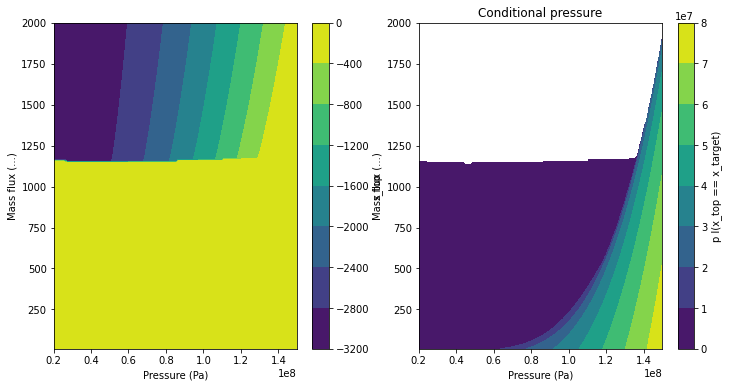

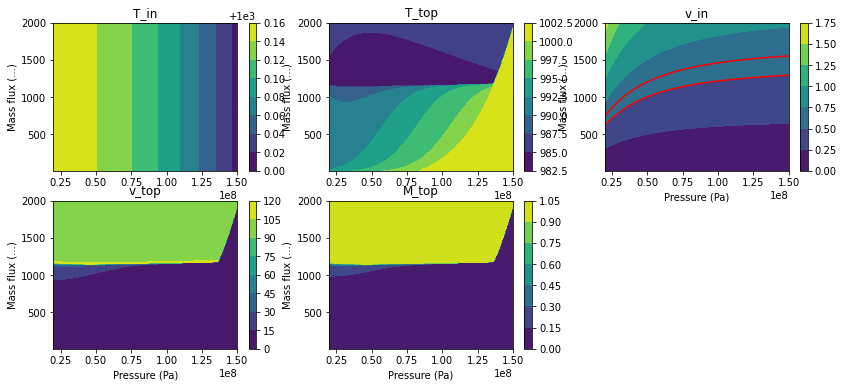

In [54]:
# Apply filtering
mg_p_top_conditional = np.where(mg_x_top >= -150, mg_p_top, np.nan)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.contourf(mg_p, mg_j0, mg_x_top)
plt.xlabel("Pressure (Pa)")
plt.ylabel("Mass flux (...)")
cb = plt.colorbar(label="x_top")

plt.subplot(1,2,2)
plt.contourf(mg_p, mg_j0, mg_p_top_conditional)
plt.xlabel("Pressure (Pa)")
plt.ylabel("Mass flux (...)")
cb = plt.colorbar(label="p I(x_top == x_target)")
plt.title("Conditional pressure")

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.contourf(mg_p, mg_j0, mg_T_in)
plt.ylabel("Mass flux (...)")
plt.colorbar()
plt.title("T_in")
plt.subplot(2,3,2)
plt.contourf(mg_p, mg_j0, mg_T_top)
plt.ylabel("Mass flux (...)")
plt.colorbar()
plt.title("T_top")
plt.subplot(2,3,3)
plt.contourf(mg_p, mg_j0, mg_v_in)
plt.xlabel("Pressure (Pa)")
plt.ylabel("Mass flux (...)")
plt.colorbar()
plt.contour(mg_p, mg_j0, mg_v_in, levels=[0.5, 0.6], colors="red")
plt.title("v_in")
plt.subplot(2,3,4)
plt.contourf(mg_p, mg_j0, mg_v_top)
plt.xlabel("Pressure (Pa)")
plt.ylabel("Mass flux (...)")
plt.title("v_top")
plt.colorbar()
plt.subplot(2,3,5)
plt.contourf(mg_p, mg_j0, mg_M_top)
plt.xlabel("Pressure (Pa)")
plt.ylabel("Mass flux (...)")
plt.colorbar()
plt.title("M_top")

In [39]:
backp = np.linspace(50e6, 100e6, 12)

solvep = [SS.SteadyState(x1, p_vent, p, input_type='p', override_properties=props)
  for p in backp]

c:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))


Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.


c:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))


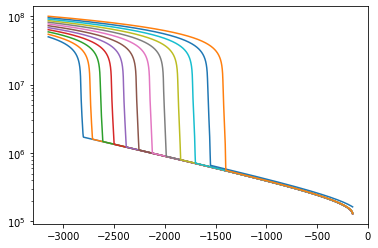

In [42]:
[plt.semilogy(x1, _f(x1, io_format="phy")[0]) for _f in solvep];

In [8]:
import steady_state as SS
# Build steady state object, extract scipy.integrate.solve_ivp inputs
f_test = SS.SteadyState(x1, p_vent, 175e6, input_type='p', override_properties=props)
f_test._DEBUG = True
f_test.solve_ssIVP(100e6, 2400)
f_test.ivp_inputs

Choked at vent.


(<function steady_state.SteadyState.solve_ssIVP.<locals>.AinvRHS(x, q, vectorized=False)>,
 (-3150.0, -150.0),
 array([1.00000000e+08, 3.03438931e+06, 5.71428571e-03, 0.00000000e+00]),
 array([-3150.  , -3149.75, -3149.5 , ...,  -150.5 ,  -150.25,  -150.  ]),
 'Radau',
 [<steady_state.SteadyState.solve_ssIVP.<locals>.EventChoked at 0x2b565bcc400>,
  <steady_state.SteadyState.solve_ssIVP.<locals>.ZeroPressure at 0x2b565bcc370>,
  <steady_state.SteadyState.solve_ssIVP.<locals>.ZeroEnthalpy at 0x2b565bcc430>,
  <steady_state.SteadyState.solve_ssIVP.<locals>.PositivePressureGradient at 0x2b565bccc70>])

In [164]:
''' Vectorizing AinvRHS '''
# f_test.T_ph(np.ones((1,3)), np.ones((1,3)), np.ones((1,3))).shape

N_vecwise = 100
# Test values
p, h, y, yF = np.ones((1,N_vecwise)), np.ones((1,N_vecwise)), \
  np.ones((1,N_vecwise)), np.ones((1,N_vecwise))
j0 = 1.0
yA = 1.0
# Compute dependents
T     = f_test.T_ph(p, h, y)
# dv_dp = y * (R / p * dT_dp(p, h, y) - R * T / p**2) + (1 - y) * dvm_dp(p)
# dv_dh = y * R / p * dT_dh(p, h, y)
# dv_dy = (v_wv(p, T) - v_m(p)) + y * R / p * dT_dy(p, T, y)
v     = f_test.v_mix(p, T, y) 
u     = j0 * v
# Compute first column of A^{-1}:(2,1)
a1 = np.vstack((np.ones_like(v), v)) / (1+j0**2 * f_test.dv_dp(p, T, y) \
  + v * j0**2 * f_test.dv_dh(p, T, y))
# Compute z == -A^{-1} * b / u
z = -j0**2 * f_test.dv_dy(p, T, y) / u * a1
# yL = 1.0 - yWt - yC - yA
yM = 1.0 - y - yA

# Simulacra
_Y = p.copy()
_F_rho = p.copy()
_out = _Y * np.vstack((z,  1/u, np.zeros_like(u))) \
  + _F_rho * np.vstack((a1, np.zeros((2, p.shape[-1])))) \
  + np.vstack([np.zeros((3, p.shape[-1])), (yM - yF) / (u * f_test.tau_f)
    * np.array(f_test.vf_g(p, T, y) >= f_test.crit_volfrac).astype(float)])

In [7]:
''' Timing for different scaling strategies. '''
_x_range = f_test.ivp_inputs[1]
_L = _x_range[1] - _x_range[0]
_U0 = f_test.ivp_inputs[2]
static_scaling = np.array([10e6, 3e6, 1, 1])
_f_scaled = lambda t, y, *args, **kwargs: \
  _L * f_test.ivp_inputs[0](t, y, *args, **kwargs)

is_vec = False
solvewrap = lambda: scipy.integrate.solve_ivp(
  lambda t, y: f_test.ivp_inputs[0](t, y, vectorized=is_vec),
  *f_test.ivp_inputs[1:3],
  method="Radau",
  dense_output=False,
  events=f_test.ivp_inputs[-1],
  vectorized=is_vec)

solvewrap_scaled = lambda: scipy.integrate.solve_ivp(
  lambda t, y: _f_scaled(t, y, vectorized=is_vec),
  np.array(_x_range)/_L, _U0,
  method="Radau",
  dense_output=False,
  events=f_test.ivp_inputs[-1],
  vectorized=is_vec)
_f_scaled, (0, 1)

%timeit -n 5 solvewrap()
%timeit -n 5 solvewrap_scaled()

NameError: name 'f_test' is not defined

In [11]:
forward_p = np.linspace(5e5, 250e6, 230)
forward_j0 = np.linspace(10, 8000, 200)
mg_p, mg_j0 = np.meshgrid(forward_p, forward_j0)
out = SS.parallel_foward_map(f, mg_p, mg_j0)

In [51]:
'''Choking line sampling (inlet pressures that are closest to choking in samples)'''
# Row index (input mass flux) associated with choked flow
i_choked = np.argmin(out["x_top"] >= -150, axis=0)
# Set filter for column index that have choked flow
has_choking_filter = np.asarray(~np.all(out["x_top"] >= -150, axis=0) 
         & ~np.all(out["x_top"] < -150, axis=0)).nonzero()[0]
i_choked = i_choked[has_choking_filter]
j_choked = np.arange(mg_p.shape[1])[has_choking_filter]
# Column index (input mass flux) associated with choked flow

# p_choked = out["p_top"][i_choked, j_choked]
p_choked = out["p_top"][i_choked, j_choked]
vel_in_choked = out["vel_in"][i_choked, j_choked]
p_in_choked = mg_p[i_choked, j_choked]

Text(0.5, 1.0, 'Inlet velocity-pressure relation at choked state')

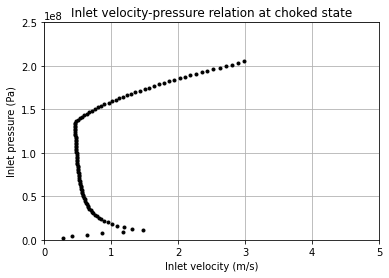

In [55]:
''' Plot p-vel relation at choking'''
plt.plot(vel_in_choked, p_in_choked, '.k')
plt.xlim(0, 5)
plt.ylim(0, 2.5e8)
plt.xlabel("Inlet velocity (m/s)")
plt.ylabel("Inlet pressure (Pa)")
plt.grid(axis="both", which="both")
plt.title("Inlet velocity-pressure relation at choked state")

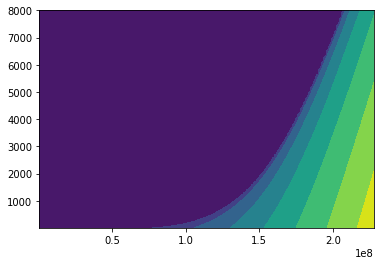

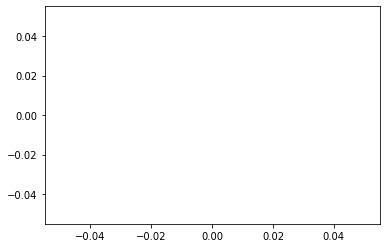

In [16]:
plt.contourf(mg_p, mg_j0, out["p_top"])
plt.figure()
plt.plot(vel_in_choked, p_in_choked)

In [114]:
%timeit scipy.integrate.solve_ivp(*f_test.ivp_inputs[0:3], method="Radau", rtol=1e-3, dense_output=False, events=f_test.ivp_inputs[-1])
# %timeit scipy.integrate.solve_ivp(*f_test.ivp_inputs[0:3], method="Radau", dense_output=False, events=f_test.ivp_inputs[-1], vectorized=True)

313 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
''' Profiling AinvRHS '''
lp = LineProfiler()
lp(f_test.ivp_inputs[0])(
  f_test.ivp_inputs[1], f_test.ivp_inputs[2])
lp.print_stats()

In [ ]:
f_raw = lambda: scipy.integrate.solve_ivp(
  *f_test.ivp_inputs[0:3],
  method="Radau",
  dense_output=False,
  events=f_test.ivp_inputs[-1])
lp(scipy.integrate.solve_ivp)(*f_test.ivp_inputs[0:3],
  method="Radau",
  dense_output=False,
  events=f_test.ivp_inputs[-1])
lp.print_stats()

In [87]:
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(f_test.solve_ssIVP)
lp_wrapper(100e6, 2400)
lp.print_stats()

Timer unit: 1e-07 s

Total time: 0.403803 s
File: c:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady\steady_state.py
Function: solve_ssIVP at line 299

Line #      Hits         Time  Per Hit   % Time  Line Contents
   299                                             def solve_ssIVP(self, p_chamber, j0, dense_output=False) -> tuple:
   300                                               ''' Solves initial value problem for (p,h,y)(x), given fully specified
   301                                               chamber (boundary) state.
   302                                               Returns:
   303                                                 t: array
   304                                                 state: array (p, h, y) (array sized 3 x ...)
   305                                                 tup: informational tuple with solve_ivp return value `soln`,
   306                                                   and system eigvals at vent) '''
   

In [7]:


f1 = SS.SteadyState(x1, p_vent, 75e6, input_type='p', override_properties=props)
f5 = SS.SteadyState(x1, p_vent, 90e6, input_type='p', override_properties=props)

soln1 = f1(x1, io_format="phy")
p1, h1, y1, yFsoln1 = soln1[0:4]
T1 = f1.T_ph(p1, h1, y1)
rho1 = 1.0 / f1.v_mix(p1, T1, y1)

soln_quail1 = f1(x_quail, io_format="quail")
u1 = f1.j0 / rho1
c_fn1 = lambda p, h, yWv: f1.mixture.sound_speed(
  p, f1.T_ph(p, h, yWv), f1.yA, yWv, 1.0 - f1.yA - yWv)
c1 = np.array(list(map(c_fn1, p1, h1, y1)))
phi1 = f1.mixture.vf_g(p1, T1, f1.yA, y1, 1.0-f1.yA-y1)

drag_fn1 = lambda p1, T1, y1, yFsoln1, rho1, u1: f1.F_fric(p1, T1, y1, yFsoln1, rho1, u1)
drag1 = np.array(list(map(drag_fn1, p1, T1, y1, yFsoln1, rho1, u1)))
eta_fn1 = lambda T1, y1, yFsoln1: f1.F_fric_viscosity_model(T1, y1, yFsoln1)
eta1 = np.array(list(map(eta_fn1, T1, y1, yFsoln1)))

soln5 = f5(x1, io_format="phy")
p5, h5, y5, yFsoln5 = soln5[0:4]
T5 = f5.T_ph(p5, h5, y5)
rho5 = 1.0 / f5.v_mix(p5, T5, y5)
soln_quail5 = f5(x_quail, io_format="quail")
u5 = f5.j0 / rho5
c_fn5 = lambda p, h, yWv: f5.mixture.sound_speed(
  p, f5.T_ph(p, h, yWv), f5.yA, yWv, 1.0 - f5.yA - yWv)
c5 = np.array(list(map(c_fn5, p5, h5, y5)))
phi5 = f5.mixture.vf_g(p5, T5, f5.yA, y5, 1.0-f5.yA-y5)
drag_fn5 = lambda p1, T1, y1, yFsoln1, rho1, u1: f5.F_fric(p1, T1, y1, yFsoln1, rho1, u1)
drag5 = np.array(list(map(drag_fn5, p5, T5, y5, yFsoln5, rho5, u5)))
eta_fn5 = lambda T1, y1, yFsoln1: f5.F_fric_viscosity_model(T1, y1, yFsoln1)
eta5 = np.array(list(map(eta_fn5, T5, y5, yFsoln5)))

Choked at vent.


c:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))


Choked at vent.


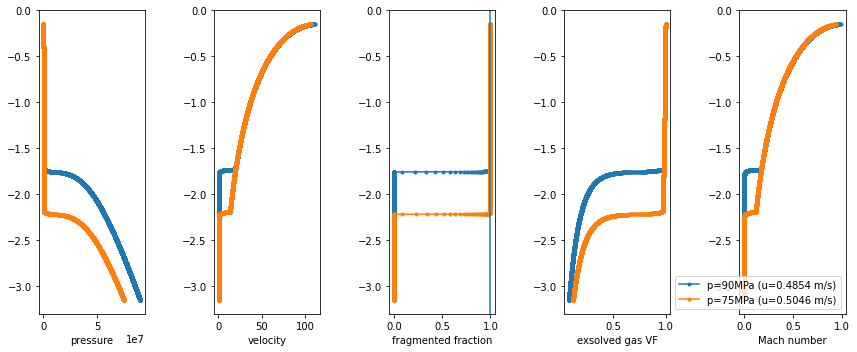

In [8]:
%matplotlib inline

x = x_global.copy()

plt.figure(figsize=(12,5))
plt.subplot(1,5,1)
plt.plot(p5, x*1e-3, '.-')
plt.plot(p1, x*1e-3, '.-')
# plt.plot(eta1 * (1 - yFsoln1 / (1.0 - y1)), x*1e-3, '.-')
# plt.plot(eta1, x*1e-3, '.-')
plt.xlabel('pressure')
plt.subplot(1,5,2)
plt.plot(u5, x*1e-3, '.-')
plt.plot(u1, x*1e-3, '.-')
plt.xlabel('velocity')
plt.subplot(1,5,3)
plt.plot(yFsoln5 / (1.0 - y5), x*1e-3, '.-')
plt.plot(yFsoln1/ (1.0 - y1), x*1e-3, '.-')
plt.axvline(1)
plt.xlabel('fragmented fraction')
plt.subplot(1,5,4)
plt.plot(phi5, x*1e-3, '.-')
plt.plot(phi1, x*1e-3, '.-')
plt.xlabel('exsolved gas VF')
plt.subplot(1,5,5)
plt.plot(u5/c5, x*1e-3, '.-', label=f'p={p5.ravel()[0]/1e6:.0f}MPa (u={u5.ravel()[0]:.4f} m/s)')
plt.plot(u1/c1, x*1e-3, '.-', label=f'p={p1.ravel()[0]/1e6:.0f}MPa (u={u1.ravel()[0]:.4f} m/s)')
plt.xlabel('Mach number')
plt.legend(loc=4)

plt.tight_layout()
# plt.savefig('/Users/kcoppess/Desktop/steadystate/exampleSoln1.png', dpi=300)
plt.show() 